#### Analyzing Neural Time Series Data
Python code for Chapter 16 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [71]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, windows
from scipy.signal.windows import dpss
from scipy.fft import fft
from scipy.io import loadmat

(-2.5, 52.5, -807.363754411426, 17174.66812748708)

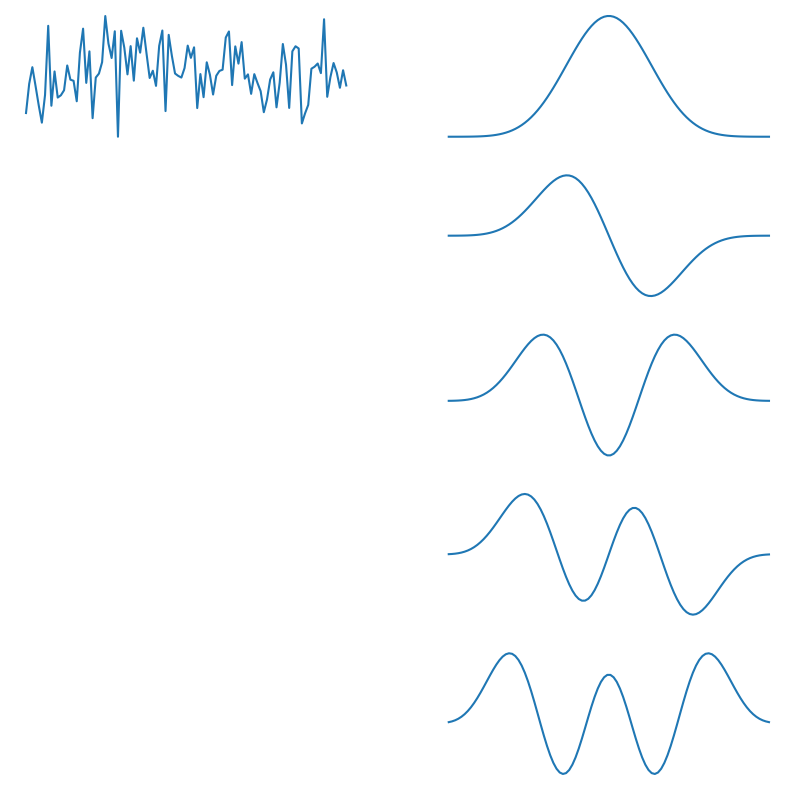

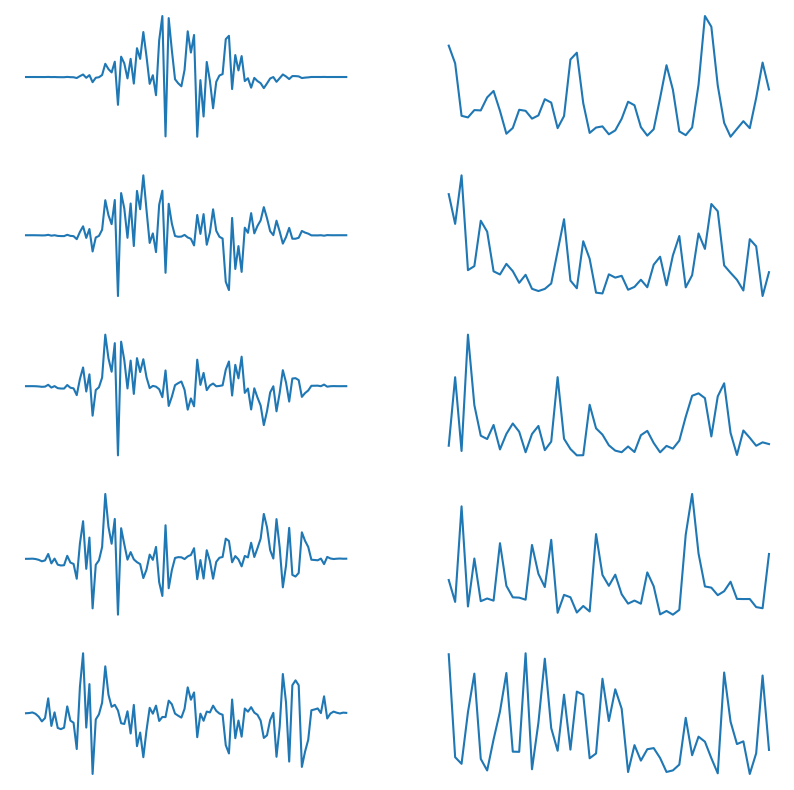

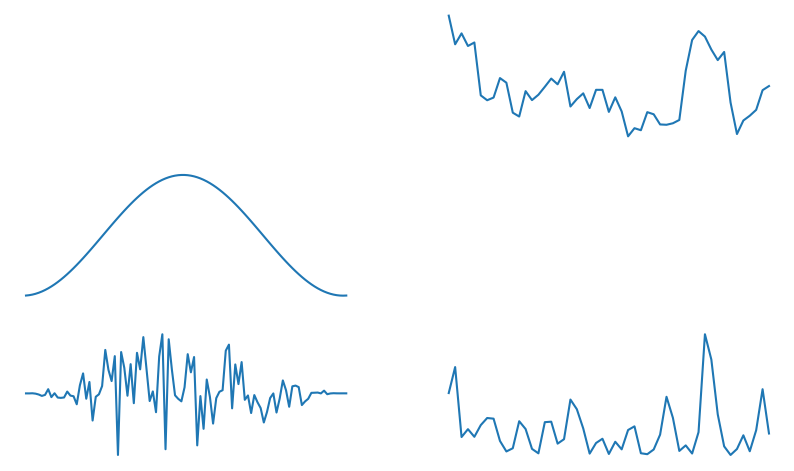

In [72]:
# Load sample EEG data
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]

# Define parameters
channel2plot = 'O1'
timewin = 400  # in ms

# Calculate the number of indices that correspond to the time window
timewinidx = round(timewin / (1000 / EEG['srate'][0][0]))
tapers = dpss(timewinidx, 5, 5)

# Extract a bit of EEG data
channel_idx = np.where(np.array([ch['labels'][0] for ch in EEG['chanlocs'][0]]) == channel2plot)[0][0]
d = detrend(EEG['data'][channel_idx, 199:199 + timewinidx, 9])

# Plot EEG data snippet
plt.figure(figsize=(10, 10))
plt.subplot(5, 2, 1)
plt.plot(d)
plt.axis('tight')
plt.axis('off')

# Plot tapers
for i in range(5):
    plt.subplot(5, 2, (2 * (i)) + 2)
    plt.plot(tapers[i, :])
    plt.axis('tight')
    plt.axis('off')

# Plot taper.*data
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 2, (2 * (i)) + 1)
    plt.plot(tapers[i, :] * d)
    plt.axis('tight')
    plt.axis('off')

# Plot fft of taper.*data
f = np.zeros((5, timewinidx)) * 1j
for i in range(5):
    plt.subplot(5, 2, (2 * (i)) + 2)
    f[i, :] = fft(tapers[i, :] * d)
    plt.plot(np.abs(f[i, :timewinidx // 2]) ** 2)
    plt.axis('tight')
    plt.axis('off')

plt.figure(figsize=(10, 10))
plt.subplot(5, 2, 2)
plt.plot(np.mean(np.abs(f[:, :timewinidx // 2]) ** 2, axis=0))
plt.axis('tight')
plt.axis('off')

plt.subplot(5, 2, 3)
hann = 0.5 * (1 - np.cos(2 * np.pi * np.arange(1, timewinidx + 1) / (timewinidx - 1)))
plt.plot(hann)
plt.axis('tight')
plt.axis('off')

plt.subplot(5, 2, 5)
plt.plot(hann * d)
plt.axis('tight')
plt.axis('off')

plt.subplot(5, 2, 6)
ff = fft(hann * d)
plt.plot(np.abs(ff[:timewinidx // 2]) ** 2)
plt.axis('tight')
plt.axis('off')

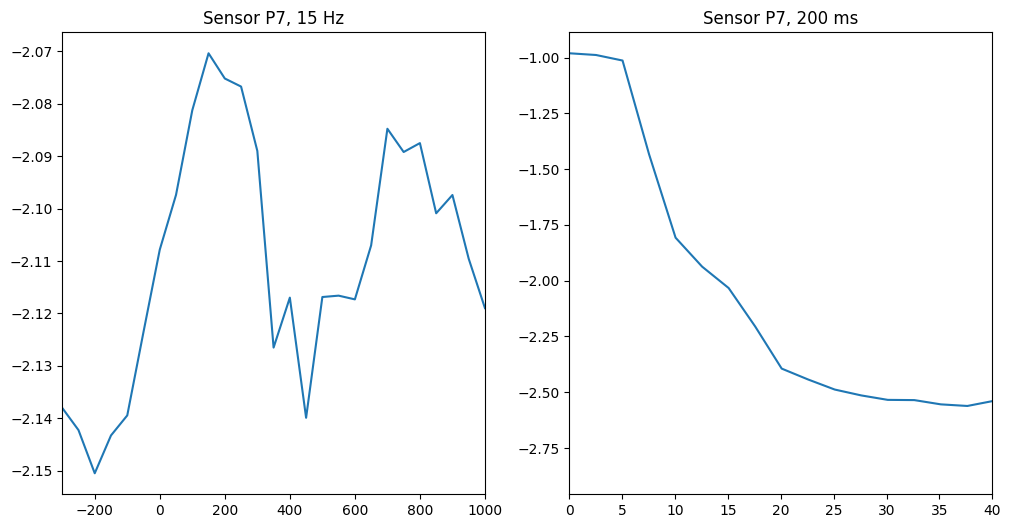

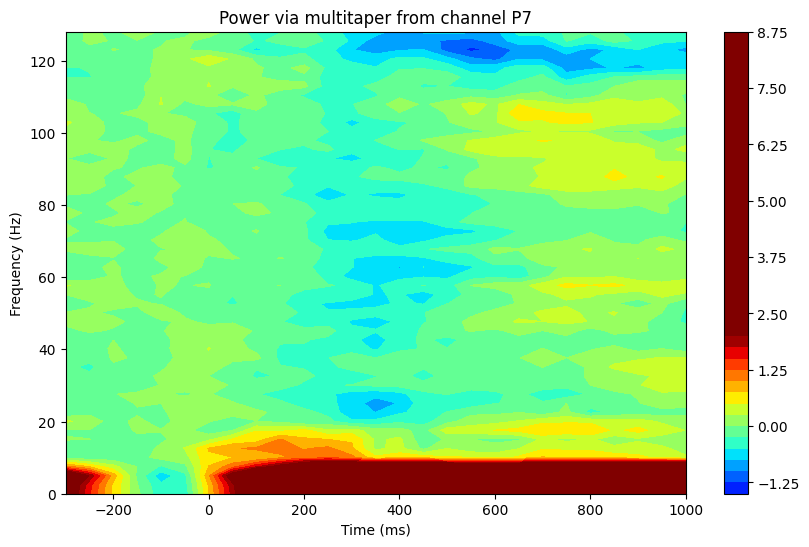

In [137]:
# Define parameters for Figure 16.2
channel2plot = 'P7'
frequency2plot = 15  # in Hz
timepoint2plot = 200  # ms
nw_product = 3  # determines the frequency smoothing, given a specified time window
times2save = np.arange(-300, 1001, 50)
baseline_range = [-200, 0]
timewin = 400  # in ms

# Convert time points to indices
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])
timewinidx = round(timewin / (1000 / EEG['srate'][0][0]))

# Find baseline time points
baseidx = [np.argmin(np.abs(times2save - br)) for br in baseline_range]

# Define tapers
tapers = dpss(timewinidx, nw_product, 6)
# Define frequencies for FFT
f = np.linspace(0, EEG['srate'][0][0] / 2, int(np.floor(timewinidx / 2)) + 1)

# Find logical channel index
chanidx = np.where(np.array([ch['labels'][0] for ch in EEG['chanlocs'][0]]) == channel2plot)[0][0]

# Initialize output matrix
multitaper_tf = np.zeros((int(np.floor(timewinidx / 2) + 1), len(times2save)))

# Loop through time bins
for ti, idx in enumerate(times2saveidx):
    # Initialize power vector (over tapers)
    taperpow = np.zeros(int(np.floor(timewinidx / 2) + 1)) * 1j
    
    # Loop through tapers
    for tapi in range(tapers.shape[0] - 1):
        # Window and taper data, and get power spectrum
        data = EEG['data'][chanidx, idx - int(np.floor(timewinidx / 2)) + 1:idx + int(np.ceil(timewinidx / 2)) + 1, :] * tapers[tapi, :][:, np.newaxis]
        pow = fft(data, timewinidx, axis=0) / timewinidx
        pow = pow[:int(np.floor(timewinidx / 2) + 1), :]
        taperpow += np.mean(pow * np.conj(pow), axis=1)
    
    # Finally, get power from closest frequency
    multitaper_tf[:, ti] = np.real(taperpow / (tapi + 1))

# dB-correct
db_multitaper_tf = 10 * np.log10(multitaper_tf / np.mean(multitaper_tf[:, baseidx[0]:baseidx[1]], axis=1)[:, np.newaxis])

# Plot time courses at one frequency band
plt.figure(figsize=(12, 6))
plt.subplot(121)
freq2plotidx = np.argmin(np.abs(f - frequency2plot)) + 1
plt.plot(times2save, np.mean(np.log10(multitaper_tf[freq2plotidx - 3:freq2plotidx + 2, :]), axis=0))
plt.title(f'Sensor {channel2plot}, {frequency2plot} Hz')
plt.xlim(times2save[0], times2save[-1])

plt.subplot(122)
time2plotidx = np.argmin(np.abs(times2save - timepoint2plot))
plt.plot(f, np.log10(multitaper_tf[:, time2plotidx]))
plt.title(f'Sensor {channel2plot}, {timepoint2plot} ms')
plt.xlim(f[0], 40)

# Plot full TF map
plt.figure(figsize=(10, 6))
plt.contourf(times2save, f, db_multitaper_tf, 40, cmap='jet')
plt.clim(-2, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Power via multitaper from channel {channel2plot}')
plt.colorbar()
plt.show()